# Setting

In [1]:
from pf_utils import BacktestManager, DataManager, StaticPortfolio, MomentumPortfolio, AssetEvaluator, metrics

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
metrics2 = [
    'total_return', 'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'
path_tran = 'transaction'

# Universe

In [3]:
from pf_widgets import w_download, w_close
display(w_download, w_close)

Checkbox(value=False, description='Download', indent=False)

Checkbox(value=False, description='Closed', indent=False)

In [4]:
# universe and file
uv_k200 = ['kospi200', 'kospi200_prices.csv']
uv_etf  = ['etf', 'etfs_all.csv']
uv_irp  = ['fund', 'funds_irp.csv']
uv_hana = ['fund', 'funds_kebhana.csv']

## KOSPI200

In [5]:
k200 = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_k200))
)
k200.upload()

200 assets from 2021-01-04 to 2024-09-20 uploaded.
df_prices updated


In [6]:
kw = dict(
    n_years=3, 
    close_today = w_close.value,
    #tickers=k200.df_prices.columns
)
k200.download(**kw) if w_download.value else None

In [7]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

## ETF

In [8]:
etf = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_etf)))
etf.upload()

889 assets from 2021-01-04 to 2024-09-20 uploaded.
df_prices updated


In [9]:
kw = dict(
    n_years=3, 
    close_today = w_close.value,
    #tickers=etf.df_prices.columns
)
etf.download(**kw) if w_download.value else None

In [10]:
choice = ['069500', '273130', '148070', '379800', '411060', '284430']
df_etf = etf.df_prices[choice]
assetnames_etf = etf.get_names(tickers=choice)
assetnames_etf

0) 069500: KODEX 200
1) 273130: KODEX 종합채권(AA-이상)액티브
2) 148070: KOSEF 국고채10년
3) 379800: KODEX 미국S&P500TR
4) 411060: ACE KRX금현물
5) 284430: KODEX 200미국채혼합

## IRP - FUNDS
- https://www.kiwoomam.com/fund/KI0202020000M?parentfundcode=8325&fundcode=8335
- https://www.kiwoomam.com/fund/KI0202020000M?parentfundcode=8370&fundcode=8380
- https://investments.miraeasset.com/fund/view.do?fundGb=2&fundCd=537380&childFundGb=2&childFundCd=53738P
- https://investments.miraeasset.com/fund/view.do?fundGb=2&fundCd=537400&childFundGb=2&childFundCd=53740P
- https://investments.miraeasset.com/fund/view.do?fundGb=2&fundCd=537410&childFundGb=2&childFundCd=53741P
- https://www.hanwhawm.com/main/finance/fundInfo/FI141_2.cmd?p=500&item_cd=5102896

In [8]:
irp = DataManager(
    upload_type = 'rate',
    path = path_data,
    **dict(zip(['universe', 'file'], uv_irp))
)
irp.upload()
df = irp.check_days_in_year(252)

Estimating price from "data/funds_irp.csv" ...
Max error of 14 conversions: 0.16 %
14 assets from 2017-07-31 to 2024-08-26 uploaded.
df_prices updated


In [9]:
irp.convert_to_daily(True)

REMINDER: data converted to daily (days in year: 365)
Daily metrics in Performance statistics must be meaningless


In [12]:
df_irp = irp.df_prices
assetnames_irp = irp.get_names()

import pandas as pd
df_an = pd.Series(assetnames_irp).to_frame('name')

In [13]:
irp.get_date_range().sort_values('end date').join(df_an)

,start date,end date,name
K55223BT1450,2017-07-31,2024-07-31,KB온국민TDF2040증권투자신탁(주식혼합-재간접형)C-퇴직e
K55105BS5067,2017-07-31,2024-07-31,삼성한국형TDF2040증권투자신탁H[주식혼합-재간접형]C-Pe
K55210BU2435,2017-08-31,2024-07-31,신한마음편한TDF2040증권투자신탁[주식혼합-재간접형](종류C-re)
KR5223AE3357,2017-08-31,2024-07-31,kb퇴직연금배당증권자투자신탁(주식)C-E
K55365BT3694,2017-08-31,2024-07-31,kcgi코리아퇴직연금증권자투자신탁(주식)종류C-Pe2
K55207BU0715,2017-08-31,2024-07-31,교보악사파워인덱스증권자투자신탁1호(주식)C-Pe
K55203C53681,2018-04-30,2024-07-31,대신KOSPI200인덱스증권자투자신탁(주식-파생형)CPe
K55213C51890,2018-05-31,2024-07-31,한화LIFEPLUSTDF2040증권자투자신탁(혼합-재간접형)C-RPe(퇴직연금)
K55234CJ0997,2019-01-31,2024-07-31,IBK플레인바닐라EMP증권투자신탁(혼합-재간접형)C-Re
K55301BU5479,2017-08-14,2024-08-25,미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e


In [14]:
irp.performance('sharpe', 'year').join(df_an)

,daily_sharpe,monthly_sharpe,yearly_sharpe,name
K55301BU6139,0.953281,0.901074,0.59158,미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e
K55301BU5479,0.928838,0.890844,0.589447,미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e
K55365BT3694,0.640849,0.640538,0.573647,kcgi코리아퇴직연금증권자투자신탁(주식)종류C-Pe2
K55213C51890,0.749963,0.754216,0.542374,한화LIFEPLUSTDF2040증권자투자신탁(혼합-재간접형)C-RPe(퇴직연금)
K55223BT1450,0.641399,0.641106,0.484719,KB온국민TDF2040증권투자신탁(주식혼합-재간접형)C-퇴직e
K55210BU2435,0.68767,0.689062,0.478562,신한마음편한TDF2040증권투자신탁[주식혼합-재간접형](종류C-re)
K55203C53681,0.542176,0.539386,0.475771,대신KOSPI200인덱스증권자투자신탁(주식-파생형)CPe
K55206C96311,0.730614,0.628118,0.452722,키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)
K55206C95800,0.778547,0.649921,0.439991,키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)
K55207BU0715,0.468617,0.464831,0.417496,교보악사파워인덱스증권자투자신탁1호(주식)C-Pe


## HANA - FUNDS
- https://dis.kofia.or.kr

In [13]:
hana = DataManager(
    upload_type = 'rate',
    path = path_data,
    **dict(zip(['universe', 'file'], uv_hana))
)
hana.upload()
hana.get_date_range()

Estimating price from "data/funds_kebhana.csv" ...
  error: -0.00 %
  error: 0.01 %
  error: -0.00 %
  error: 0.00 %
4 assets from 2010-01-29 to 2024-07-31 uploaded.
df_prices updated


,start date,end date
KR5101888398,2010-01-29,2024-07-31
KR5370AP9956,2014-04-30,2024-07-31
KR5236AS4826,2014-05-30,2024-07-31
K55306CV9946,2019-10-31,2024-07-31


In [6]:
hana.check_days_in_year(12)

KR5101888398    12.0
KR5236AS4826    12.0
KR5370AP9956    12.0
K55306CV9946    12.0
dtype: float64

In [7]:
hana.convert_to_daily(True)

REMINDER: data converted to daily (days in year: 365)
Daily metrics in Performance statistics must be meaningless


In [8]:
df_hana = hana.df_prices
assetnames_hana = hana.get_names()
assetnames_hana

0) KR5101888398: 한국투자크레딧포커스ESG증권자투자신탁 1(채권)(C-e)
1) KR5236AS4826: 한국밸류10년투자증권투자신탁 1(채권혼합)종류C-E
2) KR5370AP9956: AB글로벌고수익증권투자신탁(채권-재간접형)종류형Ce
3) K55306CV9946: 다올글로벌멀티에셋인컴EMP증권자투자신탁[혼합-재간접형](공)종류Ce

<Axes: >

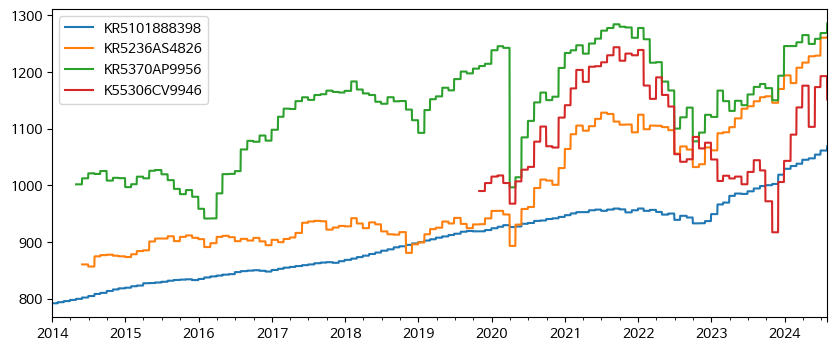

In [9]:
df_hana.loc['2014':].plot(figsize=(10,4))

# Backtest

## KOSPI 200

In [15]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 1, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year


In [16]:
lags = dict(lookback=12, lag=5)

In [17]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [18]:
select = 'Momentum'
kwargs_build = dict(
    name=f'KOSPI:{select}', select =select,
    freq='M', weigh = 'ERC',
    n_assets=5, **lags
)
bm.build(**kwargs_build)

In [29]:
select = 'K-ratio'
kwargs_build.update(dict(
    name=f'KOSPI:{select}', select =select,
))
bm.build(**kwargs_build)

In [19]:
select = 'Momentum'
n_assets = 10
kwargs_build = dict(
    name=f'KOSPI:{select}_{n_assets}', select =select,
    freq='M', weigh = 'ERC',
    n_assets=n_assets, **lags
)
bm.build(**kwargs_build)

Backtesting 3 strategies: KODEX200, KOSPI:Momentum, KOSPI:Momentum_10


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]

Returning stats


,KOSPI:Momentum,KOSPI:Momentum_10,KODEX200
start,2021-01-03,2021-01-03,2021-01-03
end,2024-08-23,2024-08-23,2024-08-23
total_return,4.681265,2.168628,0.002629
cagr,0.612504,0.373278,0.000722
calmar,2.197839,1.339425,0.002597
max_drawdown,-0.278685,-0.278685,-0.278165
avg_drawdown,-0.064276,-0.050644,-0.078234
avg_drawdown_days,17.6,25.65625,157.166667
daily_vol,0.399865,0.299541,0.156325
daily_sharpe,1.417141,1.229812,0.083251


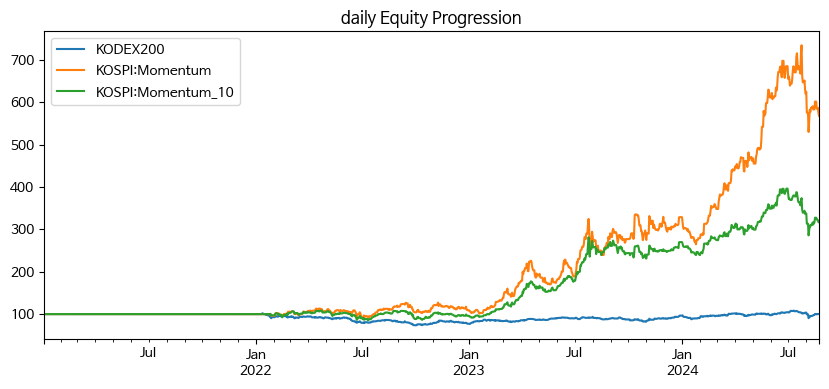

In [20]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

In [21]:
df_pf = bm.get_historical()
df_pf = df_pf[['KODEX200','KOSPI:Momentum']]

## ETF

In [38]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 245,
    asset_names = assetnames_etf
)
bm = BacktestManager(df_etf, **kwargs_bm)

period reset: 2021-12-15 ~ 2024-07-18
running self.util_check_days_in_year to check days in a year


In [39]:
lags = dict(lookback=12, lag=5)

In [40]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [41]:
kwargs_build = dict(
    freq = 'Y', select = 'all',
    **lags # added to start backtest on same date with momentum
)

bm.build(name='ETF:Eqaully', weigh='equally', **kwargs_build)
bm.build(name='ETF:ERC', weigh='ERC', **kwargs_build)
bm.build(name='ETF:InvVol', weigh='InvVol', **kwargs_build)

In [42]:
kwargs_build = dict(
    weigh='InvVol',  select = 'all',  **lags
)

bm.build(name='ETF:Eqaully(Q)', freq = 'Q', **kwargs_build)
bm.build(name='ETF:Eqaully(M)', freq = 'M', **kwargs_build)

Backtesting 6 strategies: KODEX200, ETF:Eqaully, ... , ETF:Eqaully(M)


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.79it/s]


Returning stats


,ETF:Eqaully,ETF:ERC,ETF:Eqaully(M),ETF:Eqaully(Q),ETF:InvVol,KODEX200
start,2021-12-14,2021-12-14,2021-12-14,2021-12-14,2021-12-14,2021-12-14
end,2024-07-18,2024-07-18,2024-07-18,2024-07-18,2024-07-18,2024-07-18
total_return,0.270048,0.224691,0.20629,0.202248,0.198584,0.319442
cagr,0.096586,0.081312,0.075017,0.073626,0.072363,0.112842
calmar,2.627234,2.112785,2.004658,1.991795,1.918062,0.895283
max_drawdown,-0.036763,-0.038486,-0.037421,-0.036965,-0.037727,-0.126041
avg_drawdown,-0.007541,-0.007283,-0.006064,-0.00668,-0.006697,-0.02551
avg_drawdown_days,12.216216,16.740741,15.0,16.851852,16.888889,19.192308
daily_vol,0.046106,0.040436,0.038918,0.038857,0.038869,0.125859
daily_sharpe,2.071368,2.000378,1.923199,1.891992,1.860437,0.932876


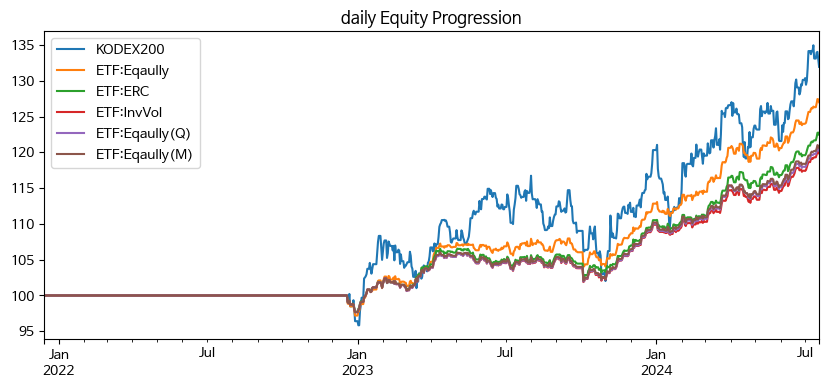

In [43]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

In [44]:
df = bm.get_historical()
df_pf = df_pf.join(df[['ETF:Eqaully', 'ETF:ERC']])

NameError: name 'df_pf' is not defined

## IRP

In [22]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 365,
    asset_names = assetnames_irp
)

lags = dict(lookback=12, lag=5)

### My portfolio

In [306]:
choice_mp = ['K55301BU6139', 'K55206C95800']
irp.get_names(choice_mp)

0) K55301BU6139: 미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e
1) K55206C95800: 키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)

In [307]:
bm = BacktestManager(df_irp, **kwargs_bm)

period reset: 2019-01-31 ~ 2024-07-31
running self.util_check_days_in_year to check days in a year


In [308]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [309]:
choice = choice_mp

kwargs_build = dict(
    # equal weights for choice, zero weights for the rest of the assets
    weigh='Specified', weights=choice,
    select ='all'
)
bm.build(name='MP:Quarterly', freq='Q', **kwargs_build)
bm.build(name='MP:Yearly', freq='Y', **kwargs_build)

In [310]:
bm.run(plot=False, stats_sort_by='monthly_sharpe', metrics=metrics2)

Backtesting 3 strategies: KODEX200, MP:Quarterly, MP:Yearly


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.82it/s]

Returning stats


,MP:Yearly,MP:Quarterly,KODEX200
start,2019-01-30,2019-01-30,2019-01-30
end,2024-07-31,2024-07-31,2024-07-31
total_return,0.5097,0.509769,0.487812
cagr,0.077764,0.077773,0.074906
monthly_vol,0.103181,0.103205,0.19921
monthly_sharpe,0.779885,0.779812,0.461712
max_drawdown,-0.215629,-0.21565,-0.346184
avg_drawdown,-0.014143,-0.014135,-0.047368
avg_drawdown_days,28.912281,28.912281,68.357143


### Weight

In [311]:
bm.benchmark_ticker(name='LAG:KODEX200', **lags)

Benchmark is LAG:KODEX200


In [312]:
kwargs_build = dict(
    freq = 'Y', select = 'all',
    **lags # added to start backtest on same date with momentum
)

choice = choice_mp
bm.build(name='LAG:MP', weigh='Specified', weights=choice, **kwargs_build)

In [313]:
bm.build(name='LAG:Eqaully', weigh='equally', **kwargs_build)
bm.build(name='LAG:ERC', weigh='ERC', **kwargs_build)
bm.build(name='LAG:InvVol', weigh='InvVol', **kwargs_build)
bm.build(name='LAG:MeanVar', weigh='MeanVar', **kwargs_build)

In [314]:
bm.portfolios

0) KODEX200
1) MP:Quarterly
2) MP:Yearly
3) LAG:KODEX200
4) LAG:MP
5) LAG:Eqaully
6) LAG:ERC
7) LAG:InvVol
8) LAG:MeanVar

In [315]:
pf_list = list(bm.portfolios.keys())[3:]
bm.run(pf_list, plot=False, stats_sort_by='monthly_sharpe', metrics=metrics2)

Backtesting 6 strategies: LAG:KODEX200, LAG:MP, ... , LAG:MeanVar


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.60it/s]

Returning stats


,LAG:MP,LAG:Eqaully,LAG:ERC,LAG:InvVol,LAG:KODEX200,LAG:MeanVar
start,2019-01-30,2019-01-30,2019-01-30,2019-01-30,2019-01-30,2019-01-30
end,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31
total_return,0.320584,0.355465,0.310493,0.301408,0.435671,0.218928
cagr,0.051856,0.056853,0.05039,0.049062,0.067957,0.036648
monthly_vol,0.099719,0.119832,0.105256,0.104687,0.189682,0.10127
monthly_sharpe,0.558104,0.522481,0.520792,0.510908,0.440919,0.406259
max_drawdown,-0.215628,-0.204365,-0.185794,-0.183714,-0.342786,-0.189489
avg_drawdown,-0.018684,-0.012366,-0.011598,-0.011269,-0.052,-0.014114
avg_drawdown_days,39.333333,35.45,29.744681,32.627907,74.619048,41.828571


In [316]:
kwb = {**kwargs_build, 'freq':'Q'}

bm.build(name='LAG:Quarterly', weigh='equally', **kwb)

In [317]:
pf_list = list(bm.portfolios.keys())[3:]
bm.run(pf_list, plot=False, stats_sort_by='monthly_sharpe', metrics=metrics2)

Backtesting 7 strategies: LAG:KODEX200, LAG:MP, ... , LAG:Quarterly


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.57it/s]

Returning stats


,LAG:MP,LAG:Eqaully,LAG:Quarterly,LAG:ERC,LAG:InvVol,LAG:KODEX200,LAG:MeanVar
start,2019-01-30,2019-01-30,2019-01-30,2019-01-30,2019-01-30,2019-01-30,2019-01-30
end,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31
total_return,0.320584,0.355465,0.354231,0.310493,0.301408,0.435671,0.218928
cagr,0.051856,0.056853,0.056678,0.05039,0.049062,0.067957,0.036648
monthly_vol,0.099719,0.119832,0.11947,0.105256,0.104687,0.189682,0.10127
monthly_sharpe,0.558104,0.522481,0.522332,0.520792,0.510908,0.440919,0.406259
max_drawdown,-0.215628,-0.204365,-0.204063,-0.185794,-0.183714,-0.342786,-0.189489
avg_drawdown,-0.018684,-0.012366,-0.012063,-0.011598,-0.011269,-0.052,-0.014114
avg_drawdown_days,39.333333,35.45,34.463415,29.744681,32.627907,74.619048,41.828571


### Select

In [318]:
n = 4
choice = irp.performance('sharpe', 'year').index[:n].to_list()
irp.get_names(choice)

0) K55301BU6139: 미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e
1) K55301BU5479: 미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e
2) K55365BT3694: kcgi코리아퇴직연금증권자투자신탁(주식)종류C-Pe2
3) K55213C51890: 한화LIFEPLUSTDF2040증권자투자신탁(혼합-재간접형)C-RPe(퇴직연금)

In [319]:
kwa_list = [{'name':f'SHP:Y{i}', 'weights':choice[:i]} for i in range(1,n+1)]

kwargs_build = dict(
    freq = 'Y', select = 'all', weigh='Specified'
)

bm.build_batch(*kwa_list, **kwargs_build)

In [320]:
bm.portfolios

0) KODEX200
1) MP:Quarterly
2) MP:Yearly
3) LAG:KODEX200
4) LAG:MP
5) LAG:Eqaully
6) LAG:ERC
7) LAG:InvVol
8) LAG:MeanVar
9) LAG:Quarterly
10) SHP:Y1
11) SHP:Y2
12) SHP:Y3
13) SHP:Y4

In [321]:
pf_list = [0, 2, 10, 11, 12, 13]
bm.run(pf_list, plot=False, stats_sort_by='monthly_sharpe', metrics=metrics2)

Backtesting 6 strategies: KODEX200, MP:Yearly, ... , SHP:Y4


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]

Returning stats


,SHP:Y1,SHP:Y2,SHP:Y4,SHP:Y3,MP:Yearly,KODEX200
start,2019-01-30,2019-01-30,2019-01-30,2019-01-30,2019-01-30,2019-01-30
end,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31
total_return,0.586372,0.618317,0.666064,0.682601,0.5097,0.487812
cagr,0.087514,0.091463,0.097249,0.099221,0.077764,0.074906
monthly_vol,0.099616,0.104922,0.122943,0.126855,0.103181,0.19921
monthly_sharpe,0.894809,0.889493,0.819295,0.811894,0.779885,0.461712
max_drawdown,-0.215077,-0.22212,-0.184672,-0.203328,-0.215629,-0.346184
avg_drawdown,-0.0116,-0.012311,-0.009163,-0.010896,-0.014143,-0.047368
avg_drawdown_days,20.853659,20.987805,22.973333,24.942857,28.912281,68.357143


In [322]:
n = 4
choice = irp.performance('sharpe', 'month').index[:n].to_list()
irp.get_names(choice)

0) K55301BU6139: 미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e
1) K55301BU5479: 미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e
2) K55301BU5453: 미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e
3) K55213C51890: 한화LIFEPLUSTDF2040증권자투자신탁(혼합-재간접형)C-RPe(퇴직연금)

In [323]:
kwa_list = [{'name':f'SHP:M{i}', 'weights':choice[:i]} for i in range(1,n+1)]

bm.build_batch(*kwa_list, **kwargs_build)

In [324]:
pf_list = [0, 2, 10, 14, 15, 16, 17]
bm.run(pf_list, plot=False, stats_sort_by='monthly_sharpe', metrics=metrics2)

Backtesting 7 strategies: KODEX200, MP:Yearly, ... , SHP:M4


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.92it/s]

Returning stats


,SHP:Y1,SHP:M1,SHP:M2,SHP:M3,SHP:M4,MP:Yearly,KODEX200
start,2019-01-30,2019-01-30,2019-01-30,2019-01-30,2019-01-30,2019-01-30,2019-01-30
end,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31
total_return,0.586372,0.586372,0.618317,0.496902,0.524563,0.5097,0.487812
cagr,0.087514,0.087514,0.091463,0.076097,0.079685,0.077764,0.074906
monthly_vol,0.099616,0.099616,0.104922,0.089114,0.094304,0.103181,0.19921
monthly_sharpe,0.894809,0.894809,0.889493,0.869994,0.862908,0.779885,0.461712
max_drawdown,-0.215077,-0.215077,-0.22212,-0.191431,-0.157305,-0.215629,-0.346184
avg_drawdown,-0.0116,-0.0116,-0.012311,-0.010156,-0.008272,-0.014143,-0.047368
avg_drawdown_days,20.853659,20.853659,20.987805,20.890244,20.26506,28.912281,68.357143


In [325]:
choice = irp.performance('sharpe').idxmax().unique().tolist()
irp.get_names(choice)

0) K55301BU5453: 미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e
1) K55301BU6139: 미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e

In [326]:
bm.build(name='SHP:Y1M1', weights=choice, **kwargs_build)

In [327]:
pf_list = [0, 2, 10, 18]
bm.run(pf_list, plot=False, stats_sort_by='monthly_sharpe', metrics=metrics2)

Backtesting 4 strategies: KODEX200, MP:Yearly, SHP:Y1, SHP:Y1M1


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.18it/s]

Returning stats


,SHP:Y1,SHP:Y1M1,MP:Yearly,KODEX200
start,2019-01-30,2019-01-30,2019-01-30,2019-01-30
end,2024-07-31,2024-07-31,2024-07-31,2024-07-31
total_return,0.586372,0.423583,0.5097,0.487812
cagr,0.087514,0.066316,0.077764,0.074906
monthly_vol,0.099616,0.078857,0.103181,0.19921
monthly_sharpe,0.894809,0.85584,0.779885,0.461712
max_drawdown,-0.215077,-0.172359,-0.215629,-0.346184
avg_drawdown,-0.0116,-0.008916,-0.014143,-0.047368
avg_drawdown_days,20.853659,21.481013,28.912281,68.357143


### Candis

In [328]:
choice = choice_mp + ['K55365BT3694', 'K55203C53681', 'K55234CJ0997']
irp.get_names(choice)

0) K55301BU6139: 미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e
1) K55206C95800: 키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)
2) K55365BT3694: kcgi코리아퇴직연금증권자투자신탁(주식)종류C-Pe2
3) K55203C53681: 대신KOSPI200인덱스증권자투자신탁(주식-파생형)CPe
4) K55234CJ0997: IBK플레인바닐라EMP증권투자신탁(혼합-재간접형)C-Re

In [329]:
bm.build(name='CAN1', weights=choice, **kwargs_build)

In [330]:
pf_list = [0, 2, 10, 19]
bm.run(pf_list, plot=False, stats_sort_by='monthly_sharpe', metrics=metrics2)

Backtesting 4 strategies: KODEX200, MP:Yearly, SHP:Y1, CAN1


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.28it/s]

Returning stats


,SHP:Y1,MP:Yearly,CAN1,KODEX200
start,2019-01-30,2019-01-30,2019-01-30,2019-01-30
end,2024-07-31,2024-07-31,2024-07-31,2024-07-31
total_return,0.586372,0.5097,0.588888,0.487812
cagr,0.087514,0.077764,0.087828,0.074906
monthly_vol,0.099616,0.103181,0.128152,0.19921
monthly_sharpe,0.894809,0.779885,0.722651,0.461712
max_drawdown,-0.215077,-0.215629,-0.213511,-0.346184
avg_drawdown,-0.0116,-0.014143,-0.011399,-0.047368
avg_drawdown_days,20.853659,28.912281,35.333333,68.357143


In [331]:
choice = choice_mp + ['K55365BT3694']
bm.build(name='CAN2', weights=choice, **kwargs_build)

In [332]:
pf_list = [0, 2, 10, 19, 20]
bm.run(pf_list, plot=False, stats_sort_by='monthly_sharpe', metrics=metrics2)

Backtesting 5 strategies: KODEX200, MP:Yearly, SHP:Y1, CAN1, CAN2


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.31it/s]

Returning stats


,SHP:Y1,MP:Yearly,CAN2,CAN1,KODEX200
start,2019-01-30,2019-01-30,2019-01-30,2019-01-30,2019-01-30
end,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31
total_return,0.586372,0.5097,0.609242,0.588888,0.487812
cagr,0.087514,0.077764,0.090348,0.087828,0.074906
monthly_vol,0.099616,0.103181,0.126804,0.128152,0.19921
monthly_sharpe,0.894809,0.779885,0.748086,0.722651,0.461712
max_drawdown,-0.215077,-0.215629,-0.208847,-0.213511,-0.346184
avg_drawdown,-0.0116,-0.014143,-0.012401,-0.011399,-0.047368
avg_drawdown_days,20.853659,28.912281,31.339623,35.333333,68.357143


#### Weight

In [362]:
choice = choice_mp + ['K55365BT3694', 'K55213C51890', 'K55203C53681', 'K55234CJ0997']
irp.get_names(choice)

0) K55301BU6139: 미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e
1) K55206C95800: 키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)
2) K55365BT3694: kcgi코리아퇴직연금증권자투자신탁(주식)종류C-Pe2
3) K55213C51890: 한화LIFEPLUSTDF2040증권자투자신탁(혼합-재간접형)C-RPe(퇴직연금)
4) K55203C53681: 대신KOSPI200인덱스증권자투자신탁(주식-파생형)CPe
5) K55234CJ0997: IBK플레인바닐라EMP증권투자신탁(혼합-재간접형)C-Re

In [363]:
df = df_irp[choice]
bm = BacktestManager(df, **kwargs_bm)

period reset: 2019-01-31 ~ 2024-07-31
running self.util_check_days_in_year to check days in a year


In [364]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [365]:
kwargs_build = dict(
    freq = 'Y', select = 'all',
    **lags # added to start backtest on same date with momentum
)

bm.build(name='CAN3:Eqaully', weigh='equally', **kwargs_build)
bm.build(name='CAN3:ERC', weigh='ERC', **kwargs_build)
bm.build(name='CAN3:InvVol', weigh='InvVol', **kwargs_build)
bm.build(name='CAN3:MeanVar', weigh='MeanVar', **kwargs_build)

In [366]:
bm.build(name='MP', weigh='Specified', weights=choice_mp, **kwargs_build)

In [367]:
choice = irp.performance('sharpe', 'year').index
bm.build(name=f'SHP:Y1', weigh='Specified', weights=choice[0], **kwargs_build)

In [368]:
bm.run(plot=False, stats_sort_by='monthly_sharpe', metrics=metrics2)

Backtesting 7 strategies: KODEX200, CAN3:Eqaully, ... , SHP:Y1


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.84it/s]

Returning stats


,SHP:Y1,CAN3:Eqaully,CAN3:ERC,MP,CAN3:InvVol,KODEX200,CAN3:MeanVar
start,2019-01-30,2019-01-30,2019-01-30,2019-01-30,2019-01-30,2019-01-30,2019-01-30
end,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31
total_return,0.375277,0.410699,0.36222,0.320584,0.35347,0.435671,0.239453
cagr,0.059645,0.064555,0.057809,0.051856,0.05657,0.067957,0.0398
monthly_vol,0.096018,0.121237,0.109432,0.099719,0.110411,0.189682,0.103302
monthly_sharpe,0.652645,0.577498,0.569288,0.558104,0.554492,0.440919,0.429649
max_drawdown,-0.21507,-0.196979,-0.183427,-0.215628,-0.181566,-0.342786,-0.195187
avg_drawdown,-0.014249,-0.012469,-0.012531,-0.018684,-0.011687,-0.052,-0.014138
avg_drawdown_days,25.714286,36.205128,34.121951,39.333333,32.55814,74.619048,41.542857


#### Value1

In [53]:
choice = ['K55365BT3694', 'K55203C53681', 'K55234CJ0997']
irp.get_names(choice)

0) K55365BT3694: kcgi코리아퇴직연금증권자투자신탁(주식)종류C-Pe2
1) K55203C53681: 대신KOSPI200인덱스증권자투자신탁(주식-파생형)CPe
2) K55234CJ0997: IBK플레인바닐라EMP증권투자신탁(혼합-재간접형)C-Re

In [54]:
df_v = df_pf['KOSPI:Momentum'].to_frame().join(df_irp[choice], how='outer')
bm = BacktestManager(df_v, **kwargs_bm)
bm.df_assets.head()

period reset: 2022-01-25 ~ 2024-07-31
running self.util_check_days_in_year to check days in a year


,KOSPI:Momentum,K55365BT3694,K55203C53681,K55234CJ0997
2022-01-25,100.000,1012.039352,1338.109236,1390.010967
2022-01-26,99.780,1012.039352,1338.109236,1390.010967
2022-01-27,96.064,1012.039352,1338.109236,1390.010967
2022-01-28,96.318,897.421767,1203.518615,1360.231095
2022-01-29,96.318,897.421767,1203.518615,1360.231095


In [55]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [56]:
ew = lambda *l: [x for i,x in enumerate(bm.df_assets.columns) if i in l]

kwargs_build = dict(
    select = 'all', weigh='Specified'
)

hy = round(bm.days_in_year/2)
kwa_list = [
    {'name':f'VAL1:{f}{i}', 'freq':f if f != 'HY' else hy, 'weights':ew(0, i)} 
    for i in range(1,4) for f in ['Y', 'HY', 'Q', 'M']
]

bm.build_batch(*kwa_list, **kwargs_build)
bm.build(name='VAL:Momentum', freq='Once', weights=ew(0), **kwargs_build)

In [57]:
bm.run(plot=False, stats_sort_by='monthly_sharpe', metrics=metrics2)

Backtesting 14 strategies: KODEX200, VAL1:Y1, ... , VAL:Momentum


100%|███████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.77it/s]

Returning stats


,VAL1:M1,VAL:Momentum,VAL1:Q1,VAL1:HY1,VAL1:M2,VAL1:M3,VAL1:Q2,VAL1:HY2,VAL1:Q3,VAL1:HY3,VAL1:Y1,VAL1:Y2,VAL1:Y3,KODEX200
start,2022-01-24,2022-01-24,2022-01-24,2022-01-24,2022-01-24,2022-01-24,2022-01-24,2022-01-24,2022-01-24,2022-01-24,2022-01-24,2022-01-24,2022-01-24,2022-01-24
end,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31
total_return,1.816207,5.202315,1.948988,2.275473,1.743892,1.663188,1.876178,2.216583,1.817629,2.177257,1.994999,1.929399,1.892298,0.105647
cagr,0.509093,1.065356,0.53698,0.602478,0.493571,0.475954,0.521784,0.590964,0.509396,0.583205,0.546466,0.532914,0.525168,0.040723
monthly_vol,0.299109,0.543153,0.316649,0.355989,0.304777,0.283343,0.322797,0.361163,0.305477,0.350819,0.35985,0.362872,0.350884,0.201805
monthly_sharpe,1.654736,1.642873,1.637335,1.607304,1.583744,1.576551,1.569953,1.559326,1.556125,1.529182,1.493624,1.450505,1.421477,0.318938
max_drawdown,-0.174774,-0.262851,-0.177392,-0.176973,-0.165838,-0.145682,-0.16868,-0.16879,-0.16052,-0.17093,-0.192837,-0.186211,-0.197747,-0.235302
avg_drawdown,-0.038191,-0.061554,-0.038592,-0.040179,-0.039565,-0.033912,-0.042578,-0.042454,-0.03392,-0.037747,-0.049821,-0.047745,-0.047972,-0.035817
avg_drawdown_days,21.189189,17.088889,22.571429,21.944444,22.055556,19.7,22.628571,21.27027,21.297297,20.205128,21.378378,21.916667,20.410256,51.588235


#### Value2

In [63]:
choice = ['K55365BT3694']
irp.get_names(choice)

0) K55365BT3694: kcgi코리아퇴직연금증권자투자신탁(주식)종류C-Pe2

In [64]:
df_v = df_pf['KOSPI:Momentum'].to_frame().join(df_irp[choice], how='outer')
bm = BacktestManager(df_v, **kwargs_bm)
bm.df_assets.head()

period reset: 2022-01-25 ~ 2024-07-31
running self.util_check_days_in_year to check days in a year


,KOSPI:Momentum,K55365BT3694
2022-01-25,100.000,1012.039352
2022-01-26,99.780,1012.039352
2022-01-27,96.064,1012.039352
2022-01-28,96.318,897.421767
2022-01-29,96.318,897.421767


In [65]:
kwargs_build = dict(
    select = 'all', **lags
)

kwa_list = [
    {'name':f'VAL2:{f}', 'freq':f if f != 'HY' else hy} for f in ['Y', 'HY', 'Q', 'M']
]

bm.build_batch(*kwa_list, weigh='ERC', **kwargs_build)
bm.build(name='VAL2:Momentum', freq='Once', weights=ew(0), weigh='Specified', **kwargs_build)
bm.run(plot=False, stats_sort_by='monthly_sharpe', metrics=metrics2)

Backtesting 5 strategies: VAL2:Y, VAL2:HY, VAL2:Q, VAL2:M, VAL2:Momentum


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Returning stats


,VAL2:Q,VAL2:M,VAL2:HY,VAL2:Momentum,VAL2:Y
start,2022-01-24,2022-01-24,2022-01-24,2022-01-24,2022-01-24
end,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31
total_return,1.367166,1.274549,1.529266,4.653043,1.477626
cagr,0.408428,0.386262,0.445997,0.990624,0.43419
monthly_vol,0.191406,0.186329,0.233586,0.515736,0.261045
monthly_sharpe,1.914088,1.873641,1.717047,1.592483,1.527195
max_drawdown,-0.123468,-0.120783,-0.146581,-0.26285,-0.170256
avg_drawdown,-0.0216,-0.018723,-0.025313,-0.055505,-0.034704
avg_drawdown_days,12.294118,11.527778,13.3125,12.228571,12.969697


In [49]:
df = bm.get_historical()
df_pf = df_pf.join(df['TDF2:Eqaully'])

## HANA

In [10]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 365,
    asset_names = assetnames_hana
)
bm = BacktestManager(df_hana, **kwargs_bm)

period reset: 2019-10-31 ~ 2024-07-31
running self.util_check_days_in_year to check days in a year


In [11]:
lags = dict(lookback=12, lag=5)

In [12]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [13]:
kwargs_build = dict(
    freq = 'Y', select = 'all',
    **lags # added to start backtest on same date with momentum
)

bm.build(name='HANA:Eqaully', weigh='equally', **kwargs_build)
bm.build(name='HANA:ERC', weigh='ERC', **kwargs_build)
bm.build(name='HANA:InvVol', weigh='InvVol', **kwargs_build)

In [14]:
kwargs_build = dict(
    weigh='InvVol',  select = 'all',  **lags
)

bm.build(name='HANA:InvVol(Q)', freq = 'Q', **kwargs_build)
bm.build(name='HANA:InvVol(M)', freq = 'M', **kwargs_build)

Backtesting 6 strategies: KODEX200, HANA:Eqaully, ... , HANA:InvVol(M)


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.16it/s]

Returning stats


,HANA:InvVol,HANA:InvVol(M),HANA:InvVol(Q),HANA:ERC,HANA:Eqaully,KODEX200
start,2019-10-30,2019-10-30,2019-10-30,2019-10-30,2019-10-30,2019-10-30
end,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31,2024-07-31
total_return,0.153301,0.128839,0.131496,0.180167,0.155502,0.317262
cagr,0.030463,0.025826,0.026333,0.035468,0.030877,0.05969
calmar,0.531545,0.397336,0.406434,0.434394,0.317349,0.174126
max_drawdown,-0.057311,-0.064998,-0.064791,-0.081649,-0.097296,-0.342796
avg_drawdown,-0.015045,-0.009759,-0.013248,-0.024826,-0.028437,-0.039924
avg_drawdown_days,128.166667,112.125,146.166667,172.0,177.8,87.133333
daily_vol,0.032006,0.032026,0.032686,0.046101,0.049326,0.153677
daily_sharpe,0.973311,0.828929,0.828294,0.7949,0.654115,0.46194


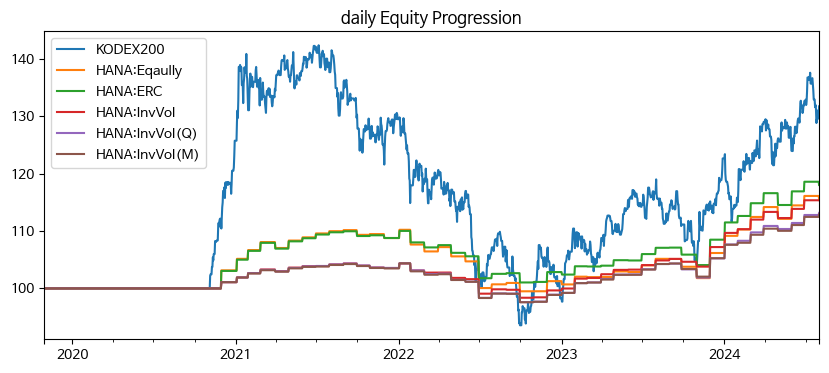

In [15]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

In [24]:
df = bm.get_historical()
df_pf = df_pf.join(df['HANA:InvVol'])

NameError: name 'df_pf' is not defined

## Summary

In [58]:
ae = AssetEvaluator(df_pf, 245)

ETF:Eqaully: 244
ETF:ERC: 244
TDF2:Eqaully: 246
HANA:InvVol: 246


In [59]:
ae.get_stats(sort_by='monthly_sharpe', align_period=False)

,ETF:Eqaully,ETF:ERC,KOSPI:Momentum,HANA:InvVol,TDF2:Eqaully,KODEX200
start,2022-12-19,2022-12-19,2022-01-25,2022-01-10,2022-01-10,2022-01-10
end,2024-07-15,2024-07-15,2024-07-15,2024-06-28,2024-06-14,2024-07-15
total_return,0.268406,0.221212,6.076125,0.105528,0.048404,0.073467
cagr,0.163337,0.135605,1.208567,0.041555,0.019678,0.02864
calmar,4.442957,3.523505,4.597925,0.725071,0.120567,0.10294
max_drawdown,-0.036763,-0.038486,-0.262851,-0.057311,-0.16321,-0.278222
avg_drawdown,-0.007653,-0.007471,-0.059227,-0.026509,-0.02669,-0.053124
avg_drawdown_days,12.527778,17.384615,17.604651,214.666667,106.375,150.666667
daily_vol,0.058874,0.051632,0.467956,0.042535,0.068992,0.173314
daily_sharpe,2.673554,2.559844,1.973106,1.001981,0.324167,0.253552


# Transaction

## KOSPI200

In [49]:
kwargs = dict(
    name='KOSPI Momentum',
    file='pf_k200_momentum.csv',
    method_select='Simple', method_weigh='ERC', lookback=12, lag=5,
    path=path_tran,
    days_in_year=246,
    asset_names=assetnames_k200,
)

pf_k200 = MomentumPortfolio(df_k200, **kwargs)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year
Transaction record to 2024-08-22 loaded.
Transaction dates updated for profit/loss on the dates


In [33]:
pf_k200.record

name   price  transaction  net  weight  weight*
date       asset                                                         
2024-07-18 003230         삼양식품  637000            5    5   0.227    0.222
           267260     HD현대일렉트릭  314000            9    9   0.198    0.193
           042700        한미반도체  149000           20   20   0.205    0.211
           000150           두산  200000           13   13   0.189    0.187
           010120  LS ELECTRIC  222000           12   12   0.181    0.187
2024-08-21 267260     HD현대일렉트릭  318000           -1    8   0.192    0.184
           003230         삼양식품  509000            1    6   0.217    0.223
           012450    한화에어로스페이스  282500           10   10   0.206    0.206
           079550       LIG넥스원  193000           14   14   0.199    0.197
           042700        한미반도체  123100            1   21   0.186    0.189
           000150           두산  147600          -13    0   0.000    0.000
           010120  LS ELECTRIC  174400          -12    0   0.000    0.000

Value 11,805,700, Profit -17.2% on 2024-09-20


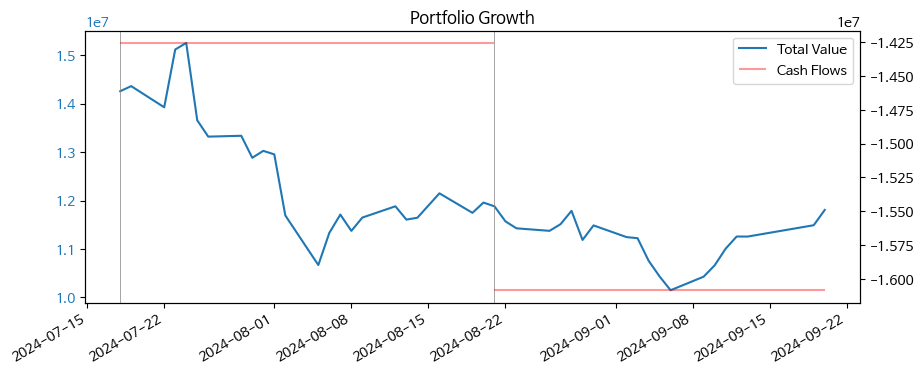

In [34]:
pf_k200.calc_value()

In [35]:
pf_k200.performance(metrics=metrics)

,KOSPI Momentum
start,2024-07-18
end,2024-09-20
total_return,-0.17182
cagr,-0.659016
calmar,-1.97042
max_drawdown,-0.334455
avg_drawdown,-0.182426
avg_drawdown_days,29.0
daily_vol,0.613004
daily_sharpe,-1.535695


In [14]:
kwargs = dict(
    #date = '2024-06-15',
    date = None,
    n_assets = 5,
    capital = 0,
    #capital = 15000000,
    save = False
    #save = True
)
pf_k200.transaction_pipeline(**kwargs)

5 assets selected by Total return from 2023-09-15 to 2024-09-13
Weights of assets determined by ERC.
Mean absolute error of weights: 8 %
Value 11,875,200, Profit -16.7%
Set save=True to save transaction record


name   price  transaction  net weight weight*
date       asset                                                       
2024-07-16 003230         삼양식품  637000            5    5  0.227   0.222
           267260     HD현대일렉트릭  314000            9    9  0.198   0.193
           042700        한미반도체  149000           20   20  0.205   0.211
           000150           두산  200000           13   13  0.189   0.187
           010120  LS ELECTRIC  222000           12   12  0.181   0.187
2024-08-19 267260     HD현대일렉트릭  318000           -1    8  0.192   0.184
           003230         삼양식품  509000            1    6  0.217   0.223
           012450    한화에어로스페이스  282500           10   10  0.206   0.206
           079550       LIG넥스원  193000           14   14  0.199   0.197
           042700        한미반도체  123100            1   21  0.186   0.189
           000150           두산  147600          -13    0    0.0     0.0
           010120  LS ELECTRIC  174400          -12    0    0.0     0.0
2024-08-28 267260     HD현대일렉트릭  305500           -1    7  0.191   0.187
           003230         삼양식품  494500           -1    5  0.217   0.216
           012450    한화에어로스페이스  290000           -2    8  0.205   0.203
           079550       LIG넥스원  195000           -2   12  0.198   0.204
           042700        한미반도체  114500           -2   19  0.189    0.19
2024-09-19 267260     HD현대일렉트릭  334000           -1    6  0.194   0.182
           003230         삼양식품  522000           -1    4  0.204    0.19
           079550       LIG넥스원  211000           -1   11  0.204   0.211
           042700        한미반도체  100300            3   22  0.191     0.2
           036460       한국가스공사   50800           47   47  0.207   0.217
           012450    한화에어로스페이스  290000           -8    0    0.0     0.0
2024-09-20 267260     HD현대일렉트릭  334000            0    6  0.188   0.183
           003230         삼양식품  522000            0    4  0.219   0.191
           012450    한화에어로스페이스  290000            8    8  0.211   0.212
           079550       LIG넥스원  211000            0   11  0.196   0.212
           042700        한미반도체  100300            0   22  0.186   0.202
           036460       한국가스공사   50800          -47    0      0       0

## testing

In [8]:
import pandas as pd

In [9]:
kwargs = dict(
    name='KOSPI Momentum',
    #file='pf_k200.csv',
    file = 'test.csv',
    method_select='Simple', method_weigh='ERC', lookback=12, lag=5,
    path=path_tran,
    days_in_year=246,
    #asset_names=assetnames_k200,
)

pf_k200 = MomentumPortfolio(df_k200, **kwargs)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year
Transaction record to 2024-09-20 loaded
Transaction dates updated for profit/loss on the dates


In [10]:
pf_k200.record

name   price  transaction  net  weight  weight*
date       asset                                                         
2024-07-17 003230         삼양식품  637000            5    5   0.227    0.222
           267260     HD현대일렉트릭  314000            9    9   0.198    0.193
           042700        한미반도체  149000           20   20   0.205    0.211
           000150           두산  200000           13   13   0.189    0.187
           010120  LS ELECTRIC  222000           12   12   0.181    0.187
2024-08-20 267260     HD현대일렉트릭  318000           -1    8   0.192    0.184
           003230         삼양식품  509000            1    6   0.217    0.223
           012450    한화에어로스페이스  282500           10   10   0.206    0.206
           079550       LIG넥스원  193000           14   14   0.199    0.197
           042700        한미반도체  123100            1   21   0.186    0.189
           000150           두산  147600          -13    0   0.000    0.000
           010120  LS ELECTRIC  174400          -12    0   0.000    0.000
2024-09-19 267260     HD현대일렉트릭  334000            4   12   0.188    0.188
           003230         삼양식품  522000            3    9   0.219    0.221
           012450    한화에어로스페이스  290000            5   15   0.211    0.204
           079550       LIG넥스원  211000            6   20   0.196    0.198
           042700        한미반도체  100300           19   40   0.186    0.188

In [ ]:
pf_k200.update_record(assetnames_k200)

In [12]:
kwargs = dict(
    #date = '2024-06-15',
    date = None,
    n_assets = 5,
    #capital = 0,
    #capital = 15000000,
    save = False
    #save = True
)
pf_k200.transaction_pipeline(**kwargs)

5 assets selected by Total return from 2023-09-15 to 2024-09-13
ERROR: check the date as no new transaction
The profit from the most recent transaction: -2,320,200


name   price  transaction  net  weight  weight*
date       asset                                                         
2024-07-17 003230         삼양식품  637000            5    5   0.227    0.222
           267260     HD현대일렉트릭  314000            9    9   0.198    0.193
           042700        한미반도체  149000           20   20   0.205    0.211
           000150           두산  200000           13   13   0.189    0.187
           010120  LS ELECTRIC  222000           12   12   0.181    0.187
2024-08-20 267260     HD현대일렉트릭  318000           -1    8   0.192    0.184
           003230         삼양식품  509000            1    6   0.217    0.223
           012450    한화에어로스페이스  282500           10   10   0.206    0.206
           079550       LIG넥스원  193000           14   14   0.199    0.197
           042700        한미반도체  123100            1   21   0.186    0.189
           000150           두산  147600          -13    0   0.000    0.000
           010120  LS ELECTRIC  174400          -12    0   0.000    0.000
2024-09-19 267260     HD현대일렉트릭  334000            4   12   0.188    0.188
           003230         삼양식품  522000            3    9   0.219    0.221
           012450    한화에어로스페이스  290000            5   15   0.211    0.204
           079550       LIG넥스원  211000            6   20   0.196    0.198
           042700        한미반도체  100300           19   40   0.186    0.188

In [31]:
pf_k200.record.index.get_level_values(0).max()

Timestamp('2024-09-19 00:00:00')

In [13]:
#def transaction_pipeline(

self = pf_k200
#date='2024-08-30'
date = None
n_assets=5 
method_select=None
method_weigh=None
weights=None
capital=0
commissions=0 
record=None
save=False

method_select = self._check_var(method_select, self.method_select)
method_weigh = self._check_var(method_weigh, self.method_weigh)

self.select(date=date, n_assets=n_assets, method=method_select)
if not self.check_new_transaction():
    # calc profit at the last transaction
    p = self._calc_record_value(self.record, True)
    print(f'The profit from the most recent transaction: {p:,}')
    #return self.record

_ = self.weigh(method_weigh, weights)
df_net = self.allocate(capital=capital, commissions=commissions)
if df_net is None:
    #return None
    pass
    
df_rec = self.transaction(df_net, record=record)
df_rec

5 assets selected by Total return from 2023-09-15 to 2024-09-13
Weights of assets determined by ERC.
Mean absolute error of weights: 8 %
Value 11,875,200, Profit -16.7%


name   price  transaction  net weight weight*
date       asset                                                       
2024-07-17 003230         삼양식품  637000            5    5  0.227   0.222
           267260     HD현대일렉트릭  314000            9    9  0.198   0.193
           042700        한미반도체  149000           20   20  0.205   0.211
           000150           두산  200000           13   13  0.189   0.187
           010120  LS ELECTRIC  222000           12   12  0.181   0.187
2024-08-20 267260     HD현대일렉트릭  318000           -1    8  0.192   0.184
           003230         삼양식품  509000            1    6  0.217   0.223
           012450    한화에어로스페이스  282500           10   10  0.206   0.206
           079550       LIG넥스원  193000           14   14  0.199   0.197
           042700        한미반도체  123100            1   21  0.186   0.189
           000150           두산  147600          -13    0    0.0     0.0
           010120  LS ELECTRIC  174400          -12    0    0.0     0.0
2024-08-29 267260     HD현대일렉트릭  305500           -1    7  0.191   0.187
           003230         삼양식품  494500           -1    5  0.217   0.216
           012450    한화에어로스페이스  290000           -2    8  0.205   0.203
           079550       LIG넥스원  195000           -2   12  0.198   0.204
           042700        한미반도체  114500           -2   19  0.189    0.19
2024-09-20 267260         None  334000           -1    6  0.188   0.189
           003230         None  522000           -1    4  0.219   0.196
           012450         None  290000            0    8  0.211   0.218
           079550         None  211000           -2   10  0.196   0.199
           042700         None  100300            2   21  0.186   0.198

In [14]:
#def select(
self = pf_k200
date=None
n_assets=5
method=None

#liquidating = ['012450', '267260']
liquidating = ['012450']
#liquidating = None

"""
date: transaction date
method: simple, k-ratio
"""
df_data = self.df_universe
method = self._check_var(method, self.method_select)
if date is not None:
    df_data = df_data.loc[:date]

# prepare data for weigh procedure
date = df_data.index.max()
dt1 = date - pd.DateOffset(days=self.lag)
dt0 = dt1 - pd.DateOffset(months=self.lookback)
df_data = df_data.loc[dt0:dt1]

if liquidating is not None:
    df_data = df_data.drop(liquidating, axis=1)

dts = df_data.index
dts = [x.strftime('%Y-%m-%d') for x in (dts.min(), dts.max())]
info_date = f'from {dts[0]} to {dts[1]}'

if method.lower() == 'k-ratio':
    rank = df_data.pct_change(1).apply(lambda x: calc_kratio(x.dropna())).sort_values(ascending=False)[:n_assets]
    method = 'K-ratio'
else: # default simple
    #rank = bt.ffn.calc_total_return(df_data).sort_values(ascending=False)[:n_assets]
    # no difference with calc_total_return as align_axis=1
    rank = df_data.apply(lambda x: x.dropna().iloc[-1]/x.dropna().iloc[0]-1).sort_values(ascending=False)[:n_assets]
    method = 'Total return'

assets = rank.index
self.selected = {'date': date, 'rank': rank, 'data': df_data[assets]}
print(f'{n_assets} assets selected by {method} {info_date}')
rank

5 assets selected by Total return from 2023-09-15 to 2024-09-13


267260    3.038462
003230    1.674358
079550    1.452607
042700    0.839187
036460    0.833333
dtype: float64

In [15]:
if not self.check_new_transaction():
    # calc profit at the last transaction
    p = self._calc_record_value(self.record, True)
    print(f'The profit from the most recent transaction: {p:,}')
    #return self.record

_ = self.weigh(method_weigh, weights)
df_net = self.allocate(capital=capital, commissions=commissions)
if df_net is None:
    #return None
    pass
    
df_rec = self.transaction(df_net, record=record)
df_rec

Weights of assets determined by ERC.
Mean absolute error of weights: 5 %
Value 11,875,200, Profit -16.7%


name   price  transaction  net weight weight*
date       asset                                                       
2024-07-17 003230         삼양식품  637000            5    5  0.227   0.222
           267260     HD현대일렉트릭  314000            9    9  0.198   0.193
           042700        한미반도체  149000           20   20  0.205   0.211
           000150           두산  200000           13   13  0.189   0.187
           010120  LS ELECTRIC  222000           12   12  0.181   0.187
2024-08-20 267260     HD현대일렉트릭  318000           -1    8  0.192   0.184
           003230         삼양식품  509000            1    6  0.217   0.223
           012450    한화에어로스페이스  282500           10   10  0.206   0.206
           079550       LIG넥스원  193000           14   14  0.199   0.197
           042700        한미반도체  123100            1   21  0.186   0.189
           000150           두산  147600          -13    0    0.0     0.0
           010120  LS ELECTRIC  174400          -12    0    0.0     0.0
2024-08-29 267260     HD현대일렉트릭  305500           -1    7  0.191   0.187
           003230         삼양식품  494500           -1    5  0.217   0.216
           012450    한화에어로스페이스  290000           -2    8  0.205   0.203
           079550       LIG넥스원  195000           -2   12  0.198   0.204
           042700        한미반도체  114500           -2   19  0.189    0.19
2024-09-20 267260         None  334000           -1    6  0.194   0.182
           003230         None  522000           -1    4  0.204   0.190
           079550         None  211000           -1   11  0.204   0.211
           042700         None  100300            3   22  0.191   0.200
           036460         None   50800           47   47  0.207   0.217
           012450          NaN  290000           -8    0      0       0

In [16]:
df_rec.loc['2024-09-20'].apply(lambda x: x.transaction * x.price, axis=1).sum()

-698500

In [17]:
df_rec.loc['2024-09-20'].apply(lambda x: x.net * x.price, axis=1).sum()

11007200

In [19]:
df_rec.loc['2024-08-29'].apply(lambda x: x.net * x.price, axis=1).sum()

11446500

In [21]:
self.save_transaction(df_rec)

All transactions saved to test_240920.csv


In [24]:
self.file

'test_240830.csv'

In [22]:
self.update_record(assetnames_k200)

REMINDER: make sure this is 1st transaction as no records provided


AttributeError: 'NoneType' object has no attribute 'name'

In [23]:
self.record

name   price  transaction  net  weight  weight*
date       asset                                                         
2024-07-17 003230         삼양식품  637000            5    5   0.227    0.222
           267260     HD현대일렉트릭  314000            9    9   0.198    0.193
           042700        한미반도체  149000           20   20   0.205    0.211
           000150           두산  200000           13   13   0.189    0.187
           010120  LS ELECTRIC  222000           12   12   0.181    0.187
2024-08-20 267260     HD현대일렉트릭  318000           -1    8   0.192    0.184
           003230         삼양식품  509000            1    6   0.217    0.223
           012450    한화에어로스페이스  282500           10   10   0.206    0.206
           079550       LIG넥스원  193000           14   14   0.199    0.197
           042700        한미반도체  123100            1   21   0.186    0.189
           000150           두산  147600          -13    0   0.000    0.000
           010120  LS ELECTRIC  174400          -12    0   0.000    0.000
2024-08-29 267260     HD현대일렉트릭  305500           -1    7   0.191    0.187
           003230         삼양식품  494500           -1    5   0.217    0.216
           012450    한화에어로스페이스  290000           -2    8   0.205    0.203
           079550       LIG넥스원  195000           -2   12   0.198    0.204
           042700        한미반도체  114500           -2   19   0.189    0.190

In [19]:
#def transaction(self, df_net, record=None):

"""
add new transaction to records
df_net: output of self.allocate
record: transaction record given as dataframe
"""
col_date = self.cols_record['date']
col_ast = self.cols_record['ast']
col_name = self.cols_record['name']
col_prc = self.cols_record['prc']
col_trs = self.cols_record['trs']
col_net = self.cols_record['net']
col_wgt = self.cols_record['wgt']
col_wgta = self.cols_record['wgta']
cols_short = [col_net, col_wgt, col_wgta]
cols_all = [col_name, col_prc, col_trs, *cols_short]
cols_int = [col_prc, col_trs, col_net]
        
date = df_net.index.get_level_values(0).max()
record = self._check_var(record, self.record)
if record is None:
    # allocation is same as transaction for the 1st time
    df_rec = df_net.assign(**{col_trs: df_net[col_net]})
else:
    if self._check_new_transaction(date, record, col_date):
        # add new to record after removing additional info except for cols_all in record
        df_rec = pd.concat([record[cols_all], df_net])
        df_prc = self.df_universe
    else:
        pass #return None
    
    # fill missing prices (ex: old price of new assets, new price of old assets)
    # use purchase prices in the record before possible adjustment of stock prices
    lidx = [df_rec.index.get_level_values(i).unique() for i in range(2)]
    midx = pd.MultiIndex.from_product(lidx).difference(df_rec.index)
    df_m = (df_prc[lidx[1]].stack().loc[midx]
             .rename_axis([col_date, col_ast]).to_frame(col_prc))
    if self.asset_names is not None: # add asset names
        df_m = df_m.join(pd.Series(self.asset_names, name=col_name), on=col_ast)
    df_rec = pd.concat([df_rec, df_m])
    
    # the net amount of the assets not in hold on the date is 0
    cond = df_rec[col_net].isna()
    cond = cond & (df_rec.index.get_level_values(0) == date)
    df_rec.loc[cond, cols_short] = 0  
    
# update transaction on the date by using the assets on the date 
# and all the transaction before the date
df_trs = (df_rec.loc[date, col_net]
          .sub(df_rec.groupby(col_ast)[col_trs].sum())
          .to_frame(col_trs).assign(**{col_date:date})
          .set_index(col_date, append=True).swaplevel())

df_trs

df_rec.update(df_trs)
df_rec = df_rec.dropna(subset=cols_short) # drop new assets before the date
df_rec

name   price  transaction   net weight weight*
date       asset                                                        
2024-07-18 003230         삼양식품  637000          5.0   5.0  0.227   0.222
           267260     HD현대일렉트릭  314000          9.0   9.0  0.198   0.193
           042700        한미반도체  149000         20.0  20.0  0.205   0.211
           000150           두산  200000         13.0  13.0  0.189   0.187
           010120  LS ELECTRIC  222000         12.0  12.0  0.181   0.187
2024-08-21 267260     HD현대일렉트릭  318000         -1.0   8.0  0.192   0.184
           003230         삼양식품  509000          1.0   6.0  0.217   0.223
           012450    한화에어로스페이스  282500         10.0  10.0  0.206   0.206
           079550       LIG넥스원  193000         14.0  14.0  0.199   0.197
           042700        한미반도체  123100          1.0  21.0  0.186   0.189
           000150           두산  147600        -13.0   0.0    0.0     0.0
           010120  LS ELECTRIC  174400        -12.0   0.0    0.0     0.0
2024-08-30 267260     HD현대일렉트릭  305500         -1.0   7.0  0.191   0.187
           003230         삼양식품  494500         -1.0   5.0  0.217   0.216
           012450    한화에어로스페이스  290000         -2.0   8.0  0.205   0.203
           079550       LIG넥스원  195000         -2.0  12.0  0.198   0.204
           042700        한미반도체  114500         -2.0  19.0  0.189   0.190
           000150           두산  149500          0.0   0.0      0       0
           010120  LS ELECTRIC  166900          0.0   0.0      0       0

In [20]:
cond = (df_rec.transaction == 0)
cond = cond & (df_rec.net == 0)
df_rec.loc[~cond]

name   price  transaction   net weight weight*
date       asset                                                        
2024-07-18 003230         삼양식품  637000          5.0   5.0  0.227   0.222
           267260     HD현대일렉트릭  314000          9.0   9.0  0.198   0.193
           042700        한미반도체  149000         20.0  20.0  0.205   0.211
           000150           두산  200000         13.0  13.0  0.189   0.187
           010120  LS ELECTRIC  222000         12.0  12.0  0.181   0.187
2024-08-21 267260     HD현대일렉트릭  318000         -1.0   8.0  0.192   0.184
           003230         삼양식품  509000          1.0   6.0  0.217   0.223
           012450    한화에어로스페이스  282500         10.0  10.0  0.206   0.206
           079550       LIG넥스원  193000         14.0  14.0  0.199   0.197
           042700        한미반도체  123100          1.0  21.0  0.186   0.189
           000150           두산  147600        -13.0   0.0    0.0     0.0
           010120  LS ELECTRIC  174400        -12.0   0.0    0.0     0.0
2024-08-30 267260     HD현대일렉트릭  305500         -1.0   7.0  0.191   0.187
           003230         삼양식품  494500         -1.0   5.0  0.217   0.216
           012450    한화에어로스페이스  290000         -2.0   8.0  0.205   0.203
           079550       LIG넥스원  195000         -2.0  12.0  0.198   0.204
           042700        한미반도체  114500         -2.0  19.0  0.189   0.190

In [ ]:



df_rec = df_rec[cols_all]
df_rec[cols_int] = df_rec[cols_int].astype(int).sort_index(level=[0,1])

## testing

In [17]:
#pf_k200.plot()

In [16]:
#pf_k200.performance(metrics=metrics2)
df_pf = pf_k200.get_historical()

## ETF

In [16]:
kwargs = dict(
    name='ETF6',
    file='pf_etf_static.csv',
    method_weigh='Equally', lookback=12, lag=5,
    path=path_tran,
    days_in_year=246,
    asset_names=assetnames_etf,
)

pf_etf = StaticPortfolio(df_etf, **kwargs)

period reset: 2021-12-15 ~ 2024-09-20
running self.util_check_days_in_year to check days in a year
Transaction record to 2024-07-18 loaded.
Transaction dates updated for profit/loss on the dates


Value 9,550,022, Profit -2.7% on 2024-09-20


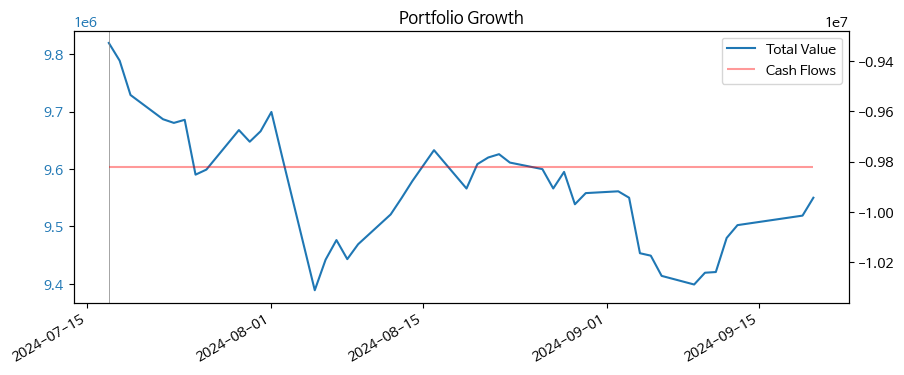

In [17]:
pf_etf.calc_value()

In [18]:
pf_etf.performance(metrics=metrics)

,ETF6
start,2024-07-17
end,2024-09-20
total_return,-0.027487
cagr,-0.144968
calmar,-3.301299
max_drawdown,-0.043912
avg_drawdown,-0.043912
avg_drawdown_days,64.0
daily_vol,0.089383
daily_sharpe,-1.782854


In [26]:
kwargs = dict(
    date = None,
    #date = '2024-07-18',
    capital = 0,
    save = False
    #save = True
)
pf_etf.transaction_pipeline(**kwargs)

6 assets from 2023-08-18 to 2024-08-16 prepared for weight analysis
Weights of assets determined by Equal weights.
Mean absolute error of weights: 1 %
Value 9,635,760, Profit -1.9%
Set save=True to save transaction record


name   price  transaction  net weight  \
date       asset                                                           
2024-07-17 069500             KODEX 200   39085           42   42  0.167   
           273130  KODEX 종합채권(AA-이상)액티브  112895           14   14  0.167   
           148070          KOSEF 국고채10년  114910           14   14  0.167   
           379800      KODEX 미국S&P500TR   17625           94   94  0.167   
           411060            ACE KRX금현물   15715          106  106  0.167   
           284430        KODEX 200미국채혼합   13440          124  124  0.167   
2024-08-23 069500             KODEX 200   36910            2   44  0.167   
           273130  KODEX 종합채권(AA-이상)액티브  113765            0   14  0.167   
           148070          KOSEF 국고채10년  116355            0   14  0.167   
           379800      KODEX 미국S&P500TR   17040            2   96  0.167   
           411060            ACE KRX금현물   15450           -1  105  0.167   
           284430        KODEX 200미국채혼합   13100            0  124  0.167   

                  weight*  
date       asset           
2024-07-17 069500   0.167  
           273130   0.161  
           148070   0.164  
           379800   0.169  
           411060    0.17  
           284430    0.17  
2024-08-23 069500   0.167  
           273130   0.164  
           148070   0.167  
           379800   0.168  
           411060   0.167  
           284430   0.167

In [21]:
df_pf = df_pf.to_frame().join(pf_etf.get_historical(), how='outer')

## IRP

In [28]:
choice = ['K55301BU6139', 'K55206C95800']

In [29]:
kwargs = dict(
    name='TDF2',
    file='pf_tdf_static.csv',
    lookback=12, lag=5,
    path=path_tran,
    days_in_year=365,
    asset_names=assetnames_irp,
)

pf_irp = StaticPortfolio(df_irp[choice], **kwargs)
pf_irp.record

period reset: 2018-07-26 ~ 2024-07-22
running self.util_check_days_in_year to check days in a year
Transaction record to 2024-06-19 loaded.
Transaction dates updated for profit/loss on the dates


name  price  \
date       asset                                                            
2024-06-18 K55301BU6139            미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e   1595   
           K55206C95800  키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)   1367   

                         transaction   net  weight  weight*  
date       asset                                             
2024-06-18 K55301BU6139         3132  3132     0.5      0.5  
           K55206C95800         3657  3657     0.5      0.5

Value 10,084,466, Profit 0.9%


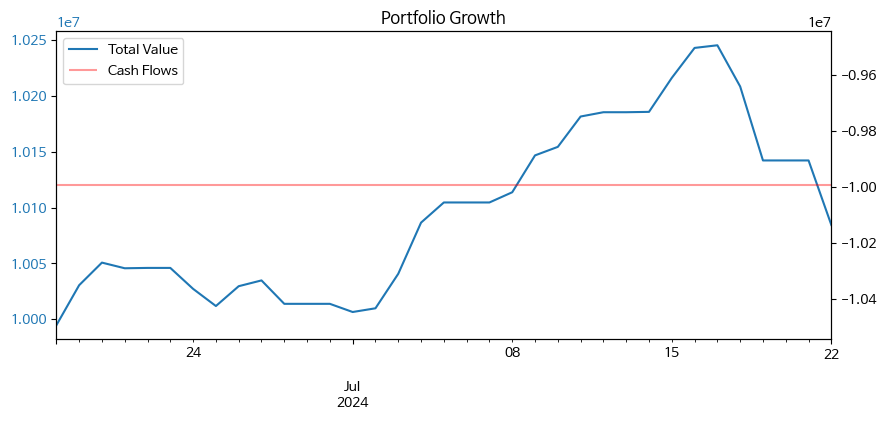

In [30]:
pf_irp.calc_value()

In [31]:
kwargs = dict(
    method_weigh = 'Equally', 
    #date = '2024-06-19',
    capital=0,
    save = False
)
pf_irp.transaction_pipeline(**kwargs)

2 assets from 2023-07-17 to 2024-07-17 prepared for weight analysis
Weights of assets determined by Equal weights.
Mean absolute error of weights: 0 %
Value 10,048,482, Profit 0.5%
Set save=True to save transaction record


name  price  \
date       asset                                                            
2024-06-18 K55301BU6139            미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e   1595   
           K55206C95800  키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)   1367   
2024-07-22 K55301BU6139            미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e   1590   
           K55206C95800  키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)   1386   

                         transaction   net weight weight*  
date       asset                                           
2024-06-18 K55301BU6139         3132  3132    0.5     0.5  
           K55206C95800         3657  3657    0.5     0.5  
2024-07-22 K55301BU6139            9  3141  0.500   0.500  
           K55206C95800          -52  3605  0.500   0.500

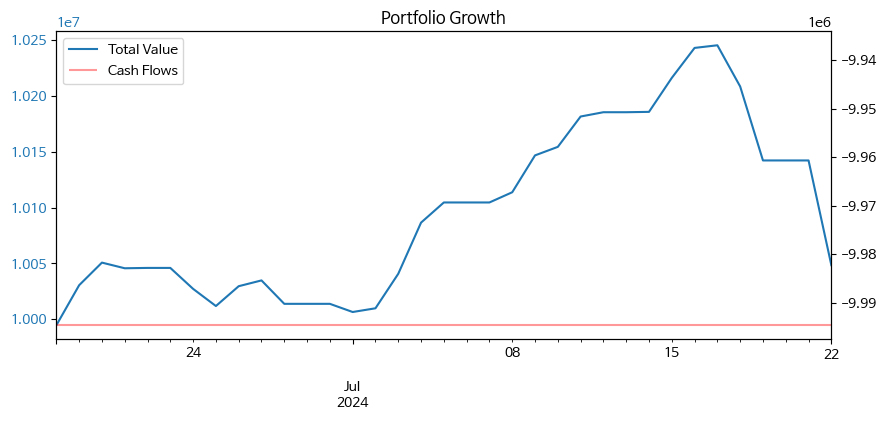

In [32]:
pf_irp.plot()

In [33]:
pf_irp.performance(metrics=metrics)

,TDF2
start,2024-06-18
end,2024-07-22
total_return,0.005385
cagr,0.059393
calmar,3.090541
max_drawdown,-0.019218
avg_drawdown,-0.011809
avg_drawdown_days,8.5
daily_vol,0.042799
daily_sharpe,0.950972


In [34]:
df_pf = df_pf.join(pf_irp.get_historical(), how='outer')
df_pf.tail()

,KOSPI Momentum,ETF6,TDF2
2024-07-18,NaN,9788950.0,1.020846e+07
2024-07-19,14255000.0,9729050.0,1.014225e+07
2024-07-20,NaN,NaN,1.014225e+07
2024-07-21,NaN,NaN,1.014225e+07
2024-07-22,13880500.0,9717710.0,1.004848e+07


## HANA

In [16]:
kwargs = dict(
    name='HANA4',
    file='pf_hana_static.csv',
    method_weigh='InvVol', lookback=12, lag=5,
    path=path_tran,
    days_in_year=365,
    asset_names=assetnames_hana,
)

pf_hana = StaticPortfolio(df_hana, **kwargs)

period reset: 2019-10-31 ~ 2024-07-31
running self.util_check_days_in_year to check days in a year
REMINDER: make sure this is 1st transaction as no records provided


In [17]:
pf_hana.calc_value()

ERROR: No transaction record


In [18]:
kwargs = dict(
    date = None,
    #date = '2024-01-01',
    capital = 10000000,
    #save = False
    save = True
)
pf_hana.transaction_pipeline(**kwargs)

4 assets from 2023-07-26 to 2024-07-26 prepared for weight analysis
Weights of assets determined by Inv.Vol.
Mean absolute error of weights: 0 %
Value 9,991,314, Profit 0.0%
All transactions saved to pf_hana_static_240731.csv


name  price  \
date       asset                                                        
2024-07-31 KR5101888398        한국투자크레딧포커스ESG증권자투자신탁 1(채권)(C-e)   1068   
           KR5236AS4826           한국밸류10년투자증권투자신탁 1(채권혼합)종류C-E   1260   
           KR5370AP9956           AB글로벌고수익증권투자신탁(채권-재간접형)종류형Ce   1285   
           K55306CV9946  다올글로벌멀티에셋인컴EMP증권자투자신탁[혼합-재간접형](공)종류Ce   1151   

                         transaction   net weight weight*  
date       asset                                           
2024-07-31 KR5101888398         4699  4699  0.502   0.502  
           KR5236AS4826         1920  1920  0.242   0.242  
           KR5370AP9956         1448  1448  0.186   0.186  
           K55306CV9946          602   602  0.069   0.069

In [40]:
#pf_hana.df_rec.set_index('name', append=True).apply(lambda x: x.price * x.transaction, axis=1).round(-4)
pf_hana.df_rec.set_index('name', append=True).weight.astype(float).mul(10000000).sum()

9990000.0

In [19]:
pf_hana.plot()

ERROR: need more data to plot


In [39]:
pf_hana.performance(metrics=metrics)

ERROR: Need more data to measure


In [41]:
df_pf = df_pf.join(pf_hana.get_historical(), how='outer')

## Summary

In [42]:
ae = AssetEvaluator(df_pf, 242)
ae.get_stats(sort_by='monthly_sharpe', align_period=False)

KOSPI Momentum: 0
ETF6: 0
TDF2: 0
HANA4: 0


,KOSPI Momentum,ETF6,TDF2,HANA4
start,2024-07-19,2024-07-17,2024-06-18,2024-06-28
end,2024-07-22,2024-07-22,2024-07-22,2024-06-28
total_return,-0.026271,-0.01041,0.005385,NaN
cagr,-0.960888,-0.534419,0.059393,NaN
calmar,-36.575313,-51.334876,3.090541,NaN
max_drawdown,-0.026271,-0.01041,-0.019218,NaN
avg_drawdown,-0.026271,-0.01041,-0.011809,NaN
avg_drawdown_days,0.0,4.0,8.5,NaN
daily_vol,NaN,0.03957,0.042799,NaN
daily_sharpe,NaN,-22.163551,0.950972,NaN


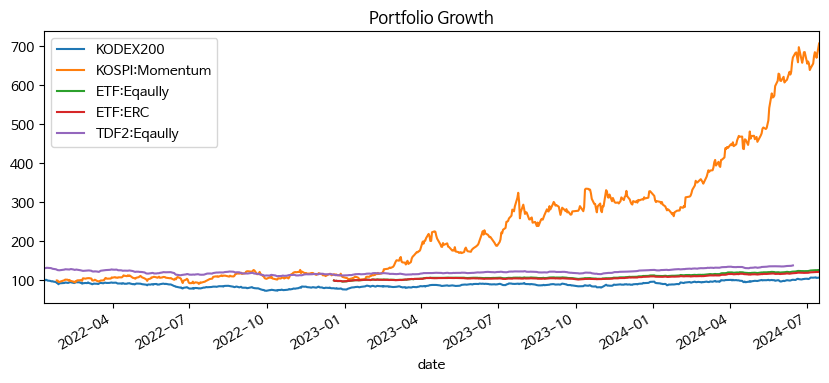

In [34]:
_ = ae.plot_historical()